# **Computational Neuroscience**

## Authors
Cesare Bergossi, Elia Parolari, Emilija Milanovic, Giulia Pezzani, Riccardo Giuseppe Carollo

## Research Question
### *Can visual stimuli that elicit similar neural responses in mice also be characterized by shared visual features? If so, what are these defining characteristics?*

## Project Overview
This project aims to utilize a clustering algorithm to analyze neural response data from mice. By focusing on specific stimuli from the "Natural Movie 1" and "Natural Scenes" datasets, we explore how similar neural activations correspond to visual similarity. The steps involved in our analysis are meticulously documented in the project notebook. Here is a brief outline of our approach:

1. **Data Compilation**: Construct a dataframe capturing the neural responses to each image. Here, 'neural response' refers to the aggregated spiking rates of neurons in response to a particular stimulus.
2. **Preprocessing and Visualization**: Implement data preprocessing and employ dimensionality reduction techniques to visualize the data.
3. **Detailed Analysis**: Perform in-depth analysis of neural responses to the "Natural Movie 1" dataset.
4. **Further Analysis**: Extend the analysis to the "Natural Scenes" dataset.
5. **Conclusions**: Draw conclusions from the comparative study of neural patterns and visual characteristics.

## Initial Setup and Data Loading

This section covers the initial steps necessary for preparing our analysis environment. We begin by loading the dataset and selecting a specific session to focus on for our explorations.

### Importing Libraries

In [3]:
import copy
import warnings
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.animation as animation
import seaborn as sns
import plotly.express as px
import plotly
import umap

from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import PowerTransformer
from sklearn.preprocessing import FunctionTransformer
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import normalize
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
# from sklearn.cluster import HDBSCAN
from sklearn.pipeline import Pipeline

from IPython.display import HTML
from IPython.display import display, Image
from yellowbrick.cluster import KElbowVisualizer
from hdbscan import HDBSCAN
import ipywidgets as widgets

from allensdk.brain_observatory.ecephys.ecephys_project_cache import EcephysProjectCache

### Custom Options for Plotting and Suppressing Warnings

In [4]:
warnings.filterwarnings("ignore", category=UserWarning)
warnings.filterwarnings("ignore", category=FutureWarning)

plotly.offline.init_notebook_mode()

%matplotlib inline

### Data Directory Configuration

Set the data directory path according to the local environment.

In [ ]:
data_dir = "/allendata"

manifest_path = os.path.join(data_dir, "manifest.json")

cache = EcephysProjectCache.from_warehouse(manifest=manifest_path)

### Image Storage Configuration

Specifying the directory where clustered images will be stored.

In [ ]:
cluster_image_root_path = '/cluster_images'

### Loading Session Data into a Dataframe

In [7]:
sessions = cache.get_session_table()
sessions.head()

published_at  specimen_id           session_type  \
id                                                                    
715093703  2019-10-03T00:00:00Z    699733581  brain_observatory_1.1   
719161530  2019-10-03T00:00:00Z    703279284  brain_observatory_1.1   
721123822  2019-10-03T00:00:00Z    707296982  brain_observatory_1.1   
732592105  2019-10-03T00:00:00Z    717038288  brain_observatory_1.1   
737581020  2019-10-03T00:00:00Z    718643567  brain_observatory_1.1   

           age_in_days sex                                    full_genotype  \
id                                                                            
715093703        118.0   M    Sst-IRES-Cre/wt;Ai32(RCL-ChR2(H134R)_EYFP)/wt   
719161530        122.0   M    Sst-IRES-Cre/wt;Ai32(RCL-ChR2(H134R)_EYFP)/wt   
721123822        125.0   M  Pvalb-IRES-Cre/wt;Ai32(RCL-ChR2(H134R)_EYFP)/wt   
732592105        100.0   M                                            wt/wt   
737581020        108.0   M                                            wt/wt   

           unit_count  channel_count  probe_count  \
id                                                  
715093703         884           2219            6   
719161530         755           2214            6   
721123822         444           2229            6   
732592105         824           1847            5   
737581020         568           2218            6   

                                  ecephys_structure_acronyms  
id                                                            
715093703  [CA1, VISrl, nan, PO, LP, LGd, CA3, DG, VISl, ...  
719161530  [TH, Eth, APN, POL, LP, DG, CA1, VISpm, nan, N...  
721123822  [MB, SCig, PPT, NOT, DG, CA1, VISam, nan, LP, ...  
732592105       [grey, VISpm, nan, VISp, VISl, VISal, VISrl]  
737581020      [grey, VISmma, nan, VISpm, VISp, VISl, VISrl]

In [8]:
sessions[sessions['age_in_days']==max(sessions['age_in_days'])]

published_at  specimen_id             session_type  \
id                                                                      
771160300  2019-10-03T00:00:00Z    754488979  functional_connectivity   

           age_in_days sex full_genotype  unit_count  channel_count  \
id                                                                    
771160300        142.0   M         wt/wt         930           2230   

           probe_count                         ecephys_structure_acronyms  
id                                                                         
771160300            6  [SCig, PPT, NOT, SUB, ProS, CA1, VISam, nan, A...

### Selecting the Desired Session
We used first the session downloaded for the tutorial class. Then we analysed the results for other mices.

In [9]:
#We ran the algorithm on different sessions
selected_session_id = 798911424
#selected_session_id = 721123822
#selected_session_id = 754829445
#selected_session_id = 732592105
#selected_session_id = 719161530
#selected_session_id = 737581020
session = cache.get_session_data(selected_session_id, timeout=1e10000)

## Firing Rate Dataframe Creation

This section details the process of creating a dataframe that encapsulates key information of interest: the average firing rate of neurons in response to each image. This metric is crucial for our analysis as it represents the neural responses to visual stimuli.

### Loading Stimulus and Units Tables
These are two tables that contain useful information and will be used during the entire analysis.

In [10]:
stimulus_table = session.get_stimulus_table()
units_table = session.units

In [11]:
stimulus_table.head(2)

stimulus_block  start_time  stop_time stimulus_name  \
stimulus_presentation_id                                                       
0                                  null   24.875987  84.942787   spontaneous   
1                                   0.0   84.942787  85.176306        gabors   

                         frame y_position color spatial_frequency contrast  \
stimulus_presentation_id                                                     
0                         null       null  null              null     null   
1                         null      -10.0  null              0.08      0.8   

                                  size                           phase  \
stimulus_presentation_id                                                 
0                                 null                            null   
1                         [20.0, 20.0]  [3644.93333333, 3644.93333333]   

                         temporal_frequency x_position orientation   duration  \
stimulus_presentation_id                                                        
0                                      null       null        null  60.066800   
1                                       4.0       20.0        90.0   0.233519   

                          stimulus_condition_id  
stimulus_presentation_id                         
0                                             0  
1                                             1

In [12]:
units_table.head(2)

waveform_PT_ratio  waveform_amplitude  amplitude_cutoff  \
unit_id                                                              
951088679           0.620607           82.147455          0.023654   
951088664           0.587044           78.399165          0.001739   

           cluster_id  cumulative_drift   d_prime  firing_rate  \
unit_id                                                          
951088679           1            480.97  2.575648     7.429131   
951088664           0            427.07  3.085334     6.843864   

           isi_violations  isolation_distance   L_ratio  ...  \
unit_id                                                  ...   
951088679        0.053350           51.364291  0.028062  ...   
951088664        0.033732           40.358293  0.051513  ...   

           ecephys_structure_id  ecephys_structure_acronym  \
unit_id                                                      
951088679                 215.0                        APN   
951088664                 215.0                        APN   

           anterior_posterior_ccf_coordinate  dorsal_ventral_ccf_coordinate  \
unit_id                                                                       
951088679                             8328.0                         3018.0   
951088664                             8328.0                         3018.0   

           left_right_ccf_coordinate  probe_description  \
unit_id                                                   
951088679                     7095.0             probeA   
951088664                     7095.0             probeA   

                          location  probe_sampling_rate  \
unit_id                                                   
951088679  See electrode locations         29999.965974   
951088664  See electrode locations         29999.965974   

           probe_lfp_sampling_rate  probe_has_lfp_data  
unit_id                                                 
951088679              1249.998582                True  
951088664              1249.998582                True  

[2 rows x 40 columns]

In [13]:
df_spike_times = session.presentationwise_spike_times()

In [14]:
df_spike_times.head(2)

stimulus_presentation_id    unit_id  \
spike_time                                        
24.876919                          0  951110751   
24.877125                          0  951106126   

            time_since_stimulus_presentation_onset  
spike_time                                          
24.876919                                 0.000933  
24.877125                                 0.001139

In [15]:
df_spike_times['count'] = np.zeros(df_spike_times.shape[0])
df_spike_counts = df_spike_times.groupby(['stimulus_presentation_id','unit_id']).count()

In [16]:
df_spike_counts = pd.pivot_table(
    data = df_spike_counts, 
    values='count', 
    index='stimulus_presentation_id', 
    columns='unit_id', 
    fill_value=0.0,
    aggfunc=np.sum
)

In [17]:
df_spike_counts.head(2)

unit_id                   951088664  951088679  951088721  951088734  \
stimulus_presentation_id                                               
0                               330        523        162        195   
1                                 2          1          0          0   

unit_id                   951088823  951088862  951088891  951088939  \
stimulus_presentation_id                                               
0                               216       2602        192        325   
1                                 0          9          0          0   

unit_id                   951088948  951088957  ...  951117252  951117258  \
stimulus_presentation_id                        ...                         
0                              2330        279  ...        269          0   
1                                 9          1  ...          0          0   

unit_id                   951117264  951117297  951117365  951117389  \
stimulus_presentation_id                                               
0                               362        564         20        125   
1                                 0          1          0          0   

unit_id                   951117418  951117426  951117435  951117571  
stimulus_presentation_id                                              
0                                 4          0          2          0  
1                                 0          0          0          0  

[2 rows x 825 columns]

In [18]:
df_firing_rates = df_spike_counts.div(stimulus_table['duration'], axis=0)

In [19]:
df_firing_rates.head()

unit_id                   951088664  951088679  951088721  951088734  \
stimulus_presentation_id                                               
0                          5.493883   8.706973   2.696997   3.246386   
1                          8.564603   4.282302   0.000000   0.000000   
2                          7.993630  15.987259   0.000000   3.996815   
3                          0.000000  11.990445   0.000000   0.000000   
4                          0.000000   7.993630  31.974519   3.996815   

unit_id                   951088823  951088862  951088891  951088939  \
stimulus_presentation_id                                               
0                          3.595996  43.318439   3.196441   5.410643   
1                          0.000000  38.540715   0.000000   0.000000   
2                          0.000000  47.961778   7.993630   7.993630   
3                          0.000000  43.964963   0.000000   0.000000   
4                          7.993630  59.952223   3.996815   0.000000   

unit_id                   951088948  951088957  ...  951117252  951117258  \
stimulus_presentation_id                        ...                         
0                         38.790147   4.644829  ...   4.478347    0.00000   
1                         38.540715   4.282302  ...   0.000000    0.00000   
2                         35.971334   7.993630  ...   3.996815    0.00000   
3                         39.968149   3.996815  ...   7.993630    0.00000   
4                         79.936297   3.996815  ...   7.993630    7.99363   

unit_id                   951117264  951117297  951117365  951117389  \
stimulus_presentation_id                                               
0                          6.026624   9.389546   0.332963   2.081016   
1                          0.000000   4.282302   0.000000   0.000000   
2                          0.000000   7.993630   0.000000   0.000000   
3                          3.996815   3.996815   0.000000   0.000000   
4                          3.996815   3.996815   0.000000   0.000000   

unit_id                   951117418  951117426  951117435  951117571  
stimulus_presentation_id                                              
0                          0.066593        0.0   0.033296        0.0  
1                          0.000000        0.0   0.000000        0.0  
2                          0.000000        0.0   0.000000        0.0  
3                          0.000000        0.0   0.000000        0.0  
4                          3.996815        0.0   0.000000        0.0  

[5 rows x 825 columns]

## Preprocessing

This section creates three new dataframes:
- `df_firing_rates_avg`: responses normalized over trials
- `df_fr_avg_visual`: for visualization purposes
- `df_fr_avg_cluster`: for clustering and further analysis

### Averaging Responses to Same Images

To attenuate trial to trial variability, if an image has been shown to the mouse for more than one time, we create a single response averaging over trials.

In [20]:
df_firing_rates_avg = pd.concat([df_firing_rates, stimulus_table[['stimulus_name', 'stimulus_condition_id']]], axis=1)

In [21]:
df_firing_rates_avg = df_firing_rates_avg.groupby(['stimulus_name', 'stimulus_condition_id']).mean()

In [22]:
df_firing_rates_avg.head()

951088664  951088679  951088721  \
stimulus_name     stimulus_condition_id                                    
drifting_gratings 246                     7.094073   8.059944  11.590352   
                  247                     6.194843   7.460438  10.158229   
                  248                     5.595306   7.926666   8.426258   
                  249                     5.495399   8.226440  13.022419   
                  250                     7.327185   7.660240  15.153965   

                                         951088734  951088823  951088862  \
stimulus_name     stimulus_condition_id                                    
drifting_gratings 246                     1.931713   2.830975  18.717697   
                  247                     1.165692   2.031650  21.948371   
                  248                     1.398828   0.766027  20.582705   
                  249                     1.332220   2.930890  18.884170   
                  250                     1.265608   4.163147  19.516942   

                                         951088891  951088939  951088948  \
stimulus_name     stimulus_condition_id                                    
drifting_gratings 246                     1.698582   4.662771  44.329680   
                  247                     1.099084   3.230641  49.425485   
                  248                     1.698577   4.229783  43.729946   
                  249                     1.232302   3.230625  49.791559   
                  250                     1.631957   3.863419  48.858990   

                                         951088957  ...  951117252  951117258  \
stimulus_name     stimulus_condition_id             ...                         
drifting_gratings 246                     3.130720  ...   3.597003   2.098256   
                  247                     3.164027  ...   7.060806   0.799336   
                  248                     3.563674  ...   2.997480   1.132390   
                  249                     3.463765  ...   7.027408   1.432136   
                  250                     2.797652  ...   5.928352   3.164004   

                                         951117264  951117297  951117365  \
stimulus_name     stimulus_condition_id                                    
drifting_gratings 246                     6.427952   2.464606   0.899246   
                  247                     7.127387   3.363857   1.165697   
                  248                     5.395460   3.130699   1.265607   
                  249                     5.595295   2.597823   1.165685   
                  250                     4.529541   1.965019   1.365522   

                                         951117389  951117418  951117426  \
stimulus_name     stimulus_condition_id                                    
drifting_gratings 246                     0.832638   0.832637   0.199835   
                  247                     0.299750   0.799331   0.333057   
                  248                     0.299748   1.831792   0.166526   
                  249                     5.029108   0.499581   0.000000   
                  250                     2.497910   1.432133   0.299745   

                                         951117435  951117571  
stimulus_name     stimulus_condition_id                        
drifting_gratings 246                     0.199834   0.466278  
                  247                     0.233139   0.000000  
                  248                     0.233138   0.099916  
                  249                     0.033306   0.333057  
                  250                     0.099916   0.133222  

[5 rows x 825 columns]

This process has reduced the dimension of the dataset drastically.

In [23]:
print(f'Responses Before Averaging: {df_firing_rates.shape[0]}')
print(f'Responses After Averaging: {df_firing_rates_avg.shape[0]}')

Responses Before Averaging: 70931
Responses After Averaging: 5063


## Data Transformation
We use two sligthly different pipelines for visualization and for further analysis.

### Visualization pipeline

In [24]:
visualization_pipeline = Pipeline([
    ('min_max_scaler', MinMaxScaler()),
    ('standard_scaler', StandardScaler())
])

### Clustering Pipeline

In [25]:
# Custom exponential transformation
def custom_root_transform(df):
    return df.applymap(lambda x: x**.7)

# Defining the pipeline
clustering_pipeline = Pipeline([
    ('sqrt_transformer', FunctionTransformer(custom_root_transform)),
    ('standard_scaler', StandardScaler()) 
])

In [26]:
def preprocess_dataframe(df,pipeline):
    '''
    Apply pipeline to a dataframe making sure
    that returend dataframe has same index
    and colmn names as the orignial
    '''
    X = pipeline.fit_transform(df)
    df_X =  pd.DataFrame(X,columns = df.columns,index = df.index)
    return df_X

### Applying the Pipelines

In [27]:
# Visualization Pipeline
df_fr_avg_visual = preprocess_dataframe(df_firing_rates_avg,visualization_pipeline)

# Clustering Pipeline
df_fr_avg_cluster = preprocess_dataframe(df_firing_rates_avg,clustering_pipeline)

### Visualizing Effect of the Transformations on the Response Distribution

In [28]:
def violin_plot_fr(df, name):
    # Select subset of columns to plot
    columns_to_plot = df.iloc[:, 0:60]

    # Violin plot of the columns
    plt.figure(figsize=(15, 6))
    sns.violinplot(data=columns_to_plot, inner="points")
    plt.title(f'Violin Plot of {name} (first 60 units)')
    plt.ylabel('firing rate preprocessed')
    plt.xlabel('unit id')
    plt.xticks(rotation=90)
    plt.show()

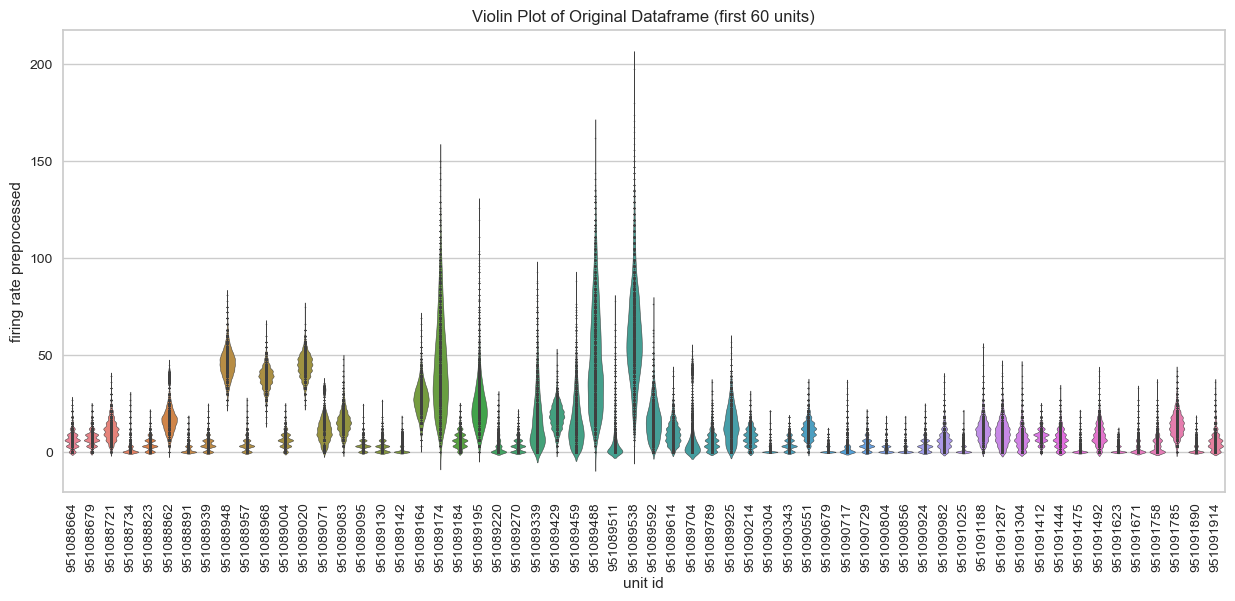

In [29]:
violin_plot_fr(df_firing_rates_avg, 'Original Dataframe')

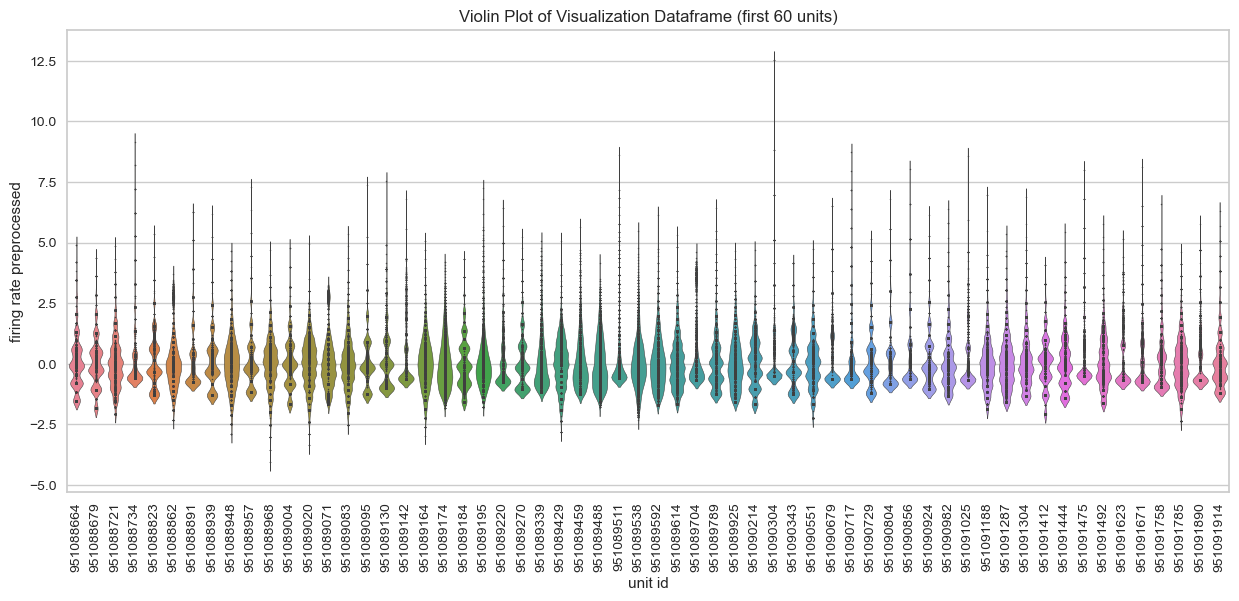

In [30]:
violin_plot_fr(df_fr_avg_visual, 'Visualization Dataframe')

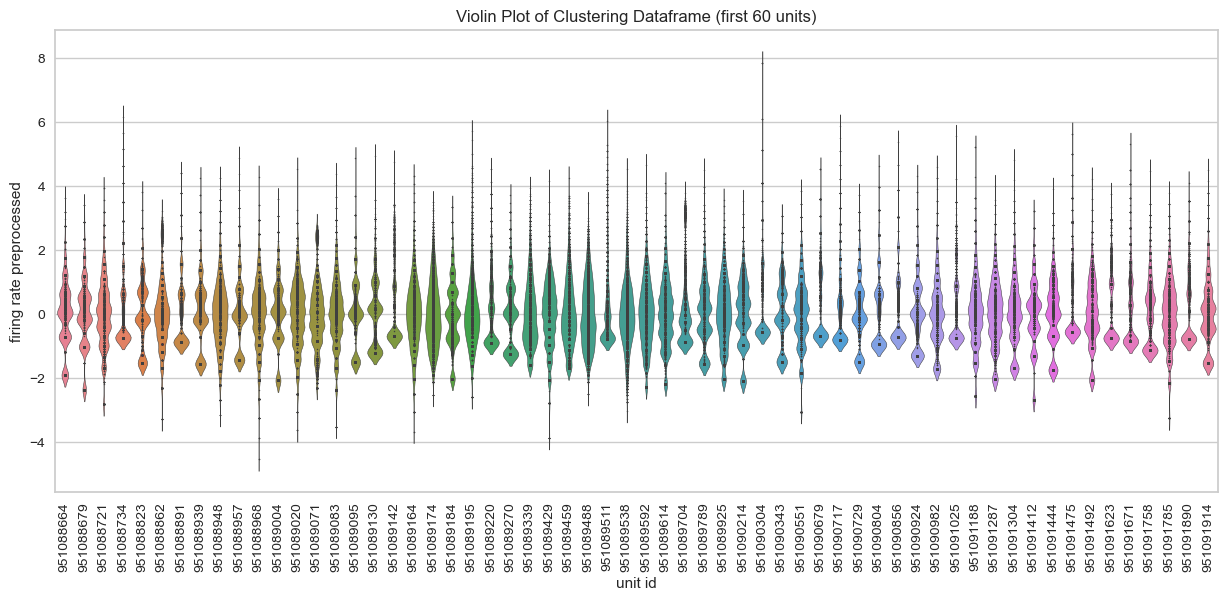

In [31]:
violin_plot_fr(df_fr_avg_cluster, 'Clustering Dataframe')

In the original dataframe, the distribution of the response for some units is highly skewed. The effect is reduced in the one for clustering, while the pipeline for visualization is a bit heavier. The purpose of the latter is having values in a specific range, to help visualization.

## Visualization

We employ two dimensionality reduction techniques, PCA and UMAP. We have decided to use 3 dimensions instead of 2 because as shown in the next plot, all the dimensions are useful, making it harder to compress the information.

### PCA (3D)

Before applying, let's see what the variance contained in the components is.

In [32]:
pca = PCA().fit(df_fr_avg_visual)

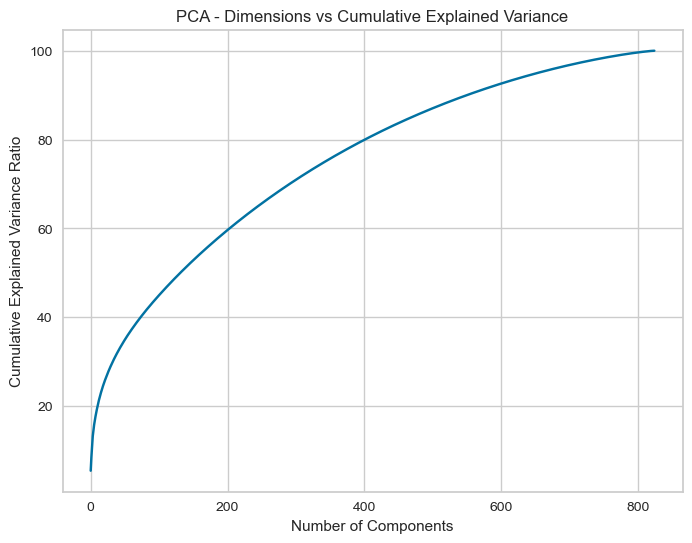

In [33]:
# Plot the variance explained by each principal component
plt.figure(figsize=(8, 6))
plt.plot(np.cumsum(pca.explained_variance_ratio_* 100) , marker='', linestyle='-')
plt.xlabel('Number of Components')
plt.ylabel('Cumulative Explained Variance Ratio')
plt.title('PCA - Dimensions vs Cumulative Explained Variance')
plt.show()

In [34]:
pca_3 = PCA(n_components=3)
components = pca_3.fit_transform(df_fr_avg_visual)
fig = px.scatter_3d(
    components, x=0, y=1, z=2,
    color=df_fr_avg_visual.index.get_level_values(0),
    #marker=dict(size=30),
    title=f'PCA - 3 Components',
    labels={'0': 'PC 1', '1': 'PC 2', '2': 'PC 3'},
)
fig.update_traces(marker=dict(size=3))
fig.update_layout(width=800, height=600)
fig.show()

### PCA & UMAP (3D)

In [35]:
# First, perform a rough dimensionality reduction using PCA to 200 components
pca_reduced = PCA(n_components=200).fit_transform(df_fr_avg_visual)

# Next, apply UMAP to reduce the dimensionality further to 3 components for 3D visualization
umap_reducer = umap.UMAP(n_components=3, n_neighbors=30, min_dist=0.3)
components = umap_reducer.fit_transform(pca_reduced)

# Create a 3D scatter plot using Plotly
fig = px.scatter_3d(
    components, x=0, y=1, z=2,
    color=df_fr_avg_visual.index.get_level_values(0),
    title='PCA -> UMAP 3D Visualization',
    labels={'0': 'PC 1', '1': 'PC 2', '2': 'PC 3'}
)
fig.update_traces(marker=dict(size=3))
fig.update_layout(width=800, height=600)
fig.show()

### Observations

It's easy to see that stimuli under the same name generate a similar response. This is actually quite surprising: why, for example, are the natural scenes all together even if the images shown were very different? 

In order to further investigate what's happening, we will focus on particular types of stimuli.

## Single Stimulus Type Analysis

### Prepare the data
Create two separate dataframes for the movie and the natural images.

In [36]:
# Copy to avoid overwriting values
df_natural_movie = copy.deepcopy(df_firing_rates_avg)
df_natural_scenes = copy.deepcopy(df_firing_rates_avg)

# Select rows correspoding to natural_movie_one
df_natural_movie = df_natural_movie.loc['natural_movie_one',:]
df_natural_scenes = df_natural_scenes.loc['natural_scenes',:]

In [37]:
df_natural_movie.head()

951088664  951088679  951088721  951088734  951088823  \
stimulus_condition_id                                                          
3887                   14.987456   8.992429   8.992399   1.498731   2.997476   
3888                    5.995012   8.992548   5.994967   1.498731   2.997536   
3889                    2.997506  11.990010   7.493683   1.498731   5.995012   
3890                    8.992384   5.994967   8.992503   7.493743   2.997491   
3891                    7.493713   7.493848   2.997506   2.997536   1.498761   

                       951088862  951088891  951088939  951088948  951088957  \
stimulus_condition_id                                                          
3887                   16.486216   0.000000   7.493758  32.972493   4.496282   
3888                   14.987381   2.997521   7.493878  41.964936   2.997506   
3889                   10.491234   1.498776   7.493848  34.471238   5.995012   
3890                   17.985097   1.498805   4.496207  38.967385   5.994907   
3891                    8.992384   2.997491   4.496252  47.959889   4.496237   

                       ...  951117252  951117258  951117264  951117297  \
stimulus_condition_id  ...                                               
3887                   ...   4.496237   2.997506   2.997476   2.997521   
3888                   ...   2.997476   2.997491   0.000000   2.997491   
3889                   ...   4.496267   1.498746   2.997506   2.997491   
3890                   ...  11.989905   4.496252   2.997446   1.498761   
3891                   ...   5.995072   2.997521   2.997476   1.498746   

                       951117365  951117389  951117418  951117426  951117435  \
stimulus_condition_id                                                          
3887                    0.000000   2.997461        0.0        0.0   0.000000   
3888                    7.493848   2.997446        0.0        0.0   0.000000   
3889                    4.496177   2.997461        0.0        0.0   1.498761   
3890                    4.496237   4.496252        0.0        0.0   0.000000   
3891                    1.498746  11.989935        0.0        0.0   0.000000   

                       951117571  
stimulus_condition_id             
3887                    0.000000  
3888                    2.997551  
3889                    0.000000  
3890                    0.000000  
3891                    0.000000  

[5 rows x 825 columns]

We would like to index the natural movie dataframe using the frame, not the condition ID.

In [38]:
stimulus_table_natural_movie = stimulus_table[stimulus_table['stimulus_name']=='natural_movie_one']
stimulus_table_natural_scenes = stimulus_table[stimulus_table['stimulus_name']=='natural_scenes']

In [39]:
stimulus_table_natural_movie.head()

stimulus_block   start_time    stop_time  \
stimulus_presentation_id                                            
22000                               4.0  2847.234747  2847.268107   
22001                               4.0  2847.268107  2847.301468   
22002                               4.0  2847.301468  2847.334829   
22003                               4.0  2847.334829  2847.368190   
22004                               4.0  2847.368190  2847.401551   

                              stimulus_name frame y_position color  \
stimulus_presentation_id                                             
22000                     natural_movie_one   0.0       null  null   
22001                     natural_movie_one   1.0       null  null   
22002                     natural_movie_one   2.0       null  null   
22003                     natural_movie_one   3.0       null  null   
22004                     natural_movie_one   4.0       null  null   

                         spatial_frequency contrast              size phase  \
stimulus_presentation_id                                                      
22000                                 null      1.0  [1920.0, 1080.0]  null   
22001                                 null      1.0  [1920.0, 1080.0]  null   
22002                                 null      1.0  [1920.0, 1080.0]  null   
22003                                 null      1.0  [1920.0, 1080.0]  null   
22004                                 null      1.0  [1920.0, 1080.0]  null   

                         temporal_frequency x_position orientation  duration  \
stimulus_presentation_id                                                       
22000                                  null       null         0.0  0.033361   
22001                                  null       null         0.0  0.033361   
22002                                  null       null         0.0  0.033361   
22003                                  null       null         0.0  0.033361   
22004                                  null       null         0.0  0.033361   

                          stimulus_condition_id  
stimulus_presentation_id                         
22000                                      3887  
22001                                      3888  
22002                                      3889  
22003                                      3890  
22004                                      3891

In [40]:
# Create a dictionary mapping stimulus_condition to stimulus_frame
stimulus_frame_dict = stimulus_table_natural_movie.set_index('stimulus_condition_id')['frame'].to_dict()

# Map stimulus_frame values from df2 to df1 based on stimulus_condition
df_natural_movie['frame'] = df_natural_movie.index.map(stimulus_frame_dict)

# Use as index
df_natural_movie = df_natural_movie.set_index('frame')

### Preprocessing

In [41]:
df_natural_scenes_prep = preprocess_dataframe(df_natural_scenes,clustering_pipeline)
df_natural_movie_prep = preprocess_dataframe(df_natural_movie,clustering_pipeline)

In [42]:
df_natural_movie_prep.head(2)

951088664  951088679  951088721  951088734  951088823  951088862  \
frame                                                                     
0.0     2.080838   0.527262  -0.301378   0.177398  -0.223438   0.106810   
1.0    -0.173618   0.527298  -1.160883   0.177398  -0.223411  -0.223973   

       951088891  951088939  951088948  951088957  ...  951117252  951117258  \
frame                                              ...                         
0.0    -1.079675   1.030914  -2.376893   0.471187  ...  -0.136294   0.516548   
1.0     0.732436   1.030951  -0.654874  -0.102929  ...  -0.677967   0.516541   

       951117264  951117297  951117365  951117389  951117418  951117426  \
frame                                                                     
0.0    -0.443660   0.556426  -1.360189   0.683231  -0.914177  -0.442735   
1.0    -1.588128   0.556412   2.494709   0.683224  -0.914177  -0.442735   

       951117435  951117571  
frame                        
0.0    -0.229798  -0.222254  
1.0    -0.229798   4.547844  

[2 rows x 825 columns]

## Natural Movie

### Download Templates

In [43]:
natural_movie = cache.get_natural_movie_template(1)

In [44]:
umap_reduced = umap.UMAP(n_components=2,n_neighbors=10,min_dist=.1).fit_transform(df_natural_movie_prep)

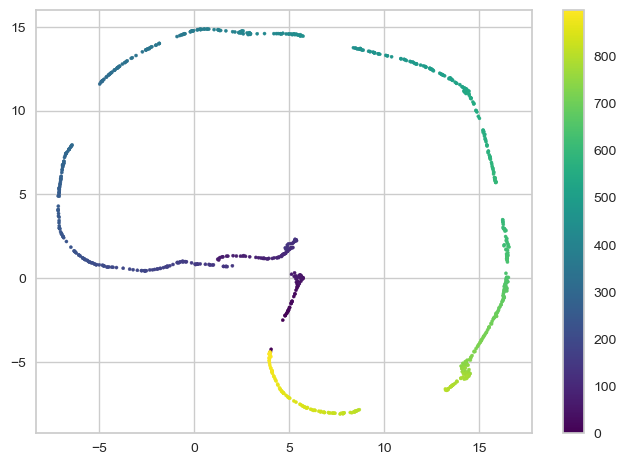

In [45]:
# Scatterplot
plt.scatter(umap_reduced[:, 0], umap_reduced[:, 1], s=5, c = df_natural_movie_prep.index, cmap='viridis')
plt.colorbar();

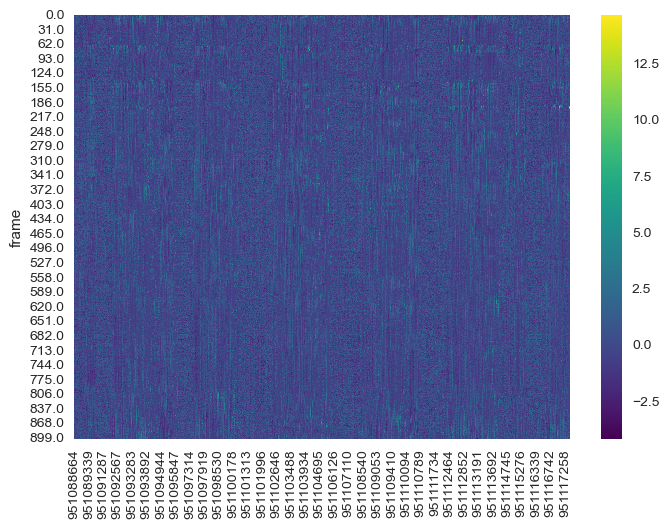

In [46]:
sns.heatmap(df_natural_movie_prep, cmap='viridis');

### Tracking Average Reaction of a Unit during Movie

In [47]:
mean_unit_reaction = df_natural_movie.mean(axis=1)

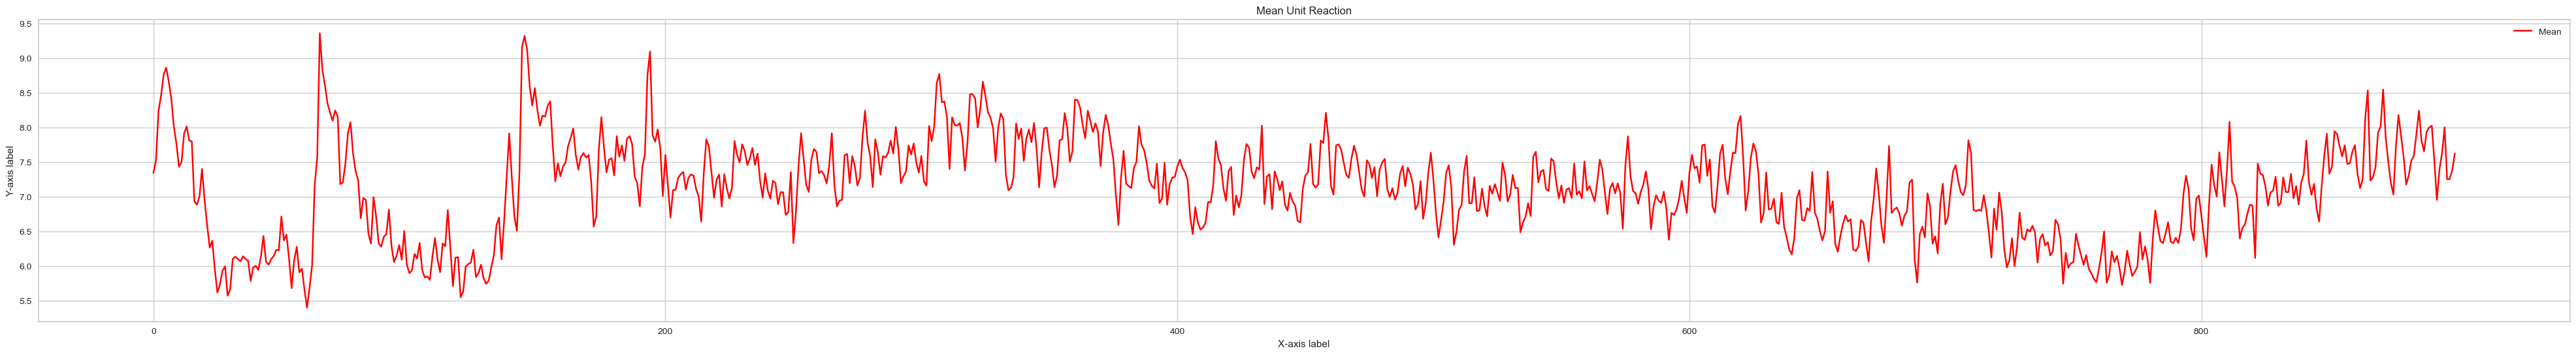

In [48]:
plt.figure(figsize=(50, 6))
plt.plot(mean_unit_reaction.index, mean_unit_reaction.values, color='red', label='Mean')
plt.legend() 
plt.xlabel('X-axis label') 
plt.ylabel('Y-axis label')
plt.title('Mean Unit Reaction')
plt.show()

In [ ]:
def number_to_color(number):
    """
    Convert a number into an RGB color tuple.
    """
    cmap = plt.get_cmap('hot')
    norm = plt.Normalize(vmin=mean_unit_reaction.min(), vmax=mean_unit_reaction.max())  # Normalize your data range
    rgba_color = cmap(norm(number))
    return rgba_color
    
fig, ax = plt.subplots()
# ims is a list of lists, each row is a list of artists to draw in the current frame; here we are just animating one artist, the image, in each frame
ims = []
texts = []  # List to store text annotations

for i in range(len(natural_movie)):
    im = ax.imshow(natural_movie[i], animated=True, cmap='gray')
    ax.axis('off')
    formatted_number = "{:.1f}".format(mean_unit_reaction[i])
    #color = number_to_color(mean_unit_reaction[i])
    s = f'Frame {i} | ' + f'Average unit reaction: {formatted_number}'
    text = ax.text(0.5, 0.95, s, ha='center', va='center', transform=ax.transAxes, color='red', fontsize=12)
    ims.append([im, text])
    texts.append(text)

ani = animation.ArtistAnimation(fig, ims, interval=1000/24, blit=True, repeat_delay=1000)
plt.rcParams['animation.embed_limit'] = np.infty

In [ ]:
HTML(ani.to_jshtml())

### Observations

Our analysis of the movie dataframe supports a positive answer to our research question. In the movie, each frame is similar to the subsequent one, and so is the response it elicits. Moreover, we can see that sudden changes in the visual sequence, such as the man moving rapidly at the beginning and his shadow on the wall, trigger an overall positive response in the neuron. This means that neurons not only respond to a particular image or pattern, but react dynamically to changes of the stimulus in time (confirming discussions from our class). 

What remains ambiguous is how much information they encode about the feature of an image versus changes within the image, and how these are connected. For instance, is the combined information of 'man' and 'moving' triggering the higher response, or only the 'moving' information alone?

## Natural Scenes

### UMAP Visualization

In [51]:

# Make sure label is removed before clustering
try:
    df_natural_scenes_prep = df_natural_scenes.drop(columns=['cluster_label'])
    df_natural_scenes = df_natural_scenes.drop(columns=['cluster_label'])
except:
    pass

# Reduce Dimensionality
pca_reduced = PCA(n_components=100).fit_transform(df_natural_scenes)
umap = umap.UMAP(n_components=3,n_neighbors=2,min_dist=.0,spread=3)
components = umap.fit_transform(pca_reduced)


# Clustering
hdb = HDBSCAN(min_cluster_size=2)
hdb.fit(components)
hdbscan_cluster_labels = hdb.labels_
print(np.unique(hdbscan_cluster_labels))
df_natural_scenes_prep['cluster_label'] = hdbscan_cluster_labels
df_natural_scenes['cluster_label'] = hdbscan_cluster_labels

fig = px.scatter_3d(
    components, x=0, y=1, z=2,
    color=hdbscan_cluster_labels,
    title=f'UMAP 3 components',
    labels={'0': 'PC 1', '1': 'PC 2', '2': 'PC 3'},
    color_continuous_scale='spectral'
)
fig.update_traces(marker=dict(size=3))
fig.update_traces(hoverinfo="none", hovertemplate=None)
fig.update_layout(width=1920, height=1080)
fig.update_layout(
        margin=dict(l=0, r=0, t=0, b=0),
        paper_bgcolor="LightSteelBlue")

[-1  0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20]


## Clusters

### Functions

In [52]:
# Assert if same stimulus condition id corresponds to unique frame
assert stimulus_table_natural_scenes.groupby('stimulus_condition_id')['frame'].apply(lambda x: x.nunique() == 1).all()

In [53]:
frame_lut = stimulus_table_natural_scenes.drop_duplicates(subset='stimulus_condition_id', keep='first').set_index('stimulus_condition_id').frame

In [54]:
cluster_label_to_frame = pd.concat([df_natural_scenes, frame_lut],axis=1)[['cluster_label','frame']]

In [55]:
def create_folder_if_not_exists(folder_path):
    if not os.path.exists(folder_path):
        os.makedirs(folder_path)
    else:
        pass
        
def delete_folder_contents(folder_path):
    for filename in os.listdir(folder_path):
        file_path = os.path.join(folder_path, filename)
        try:
            if os.path.isfile(file_path):
                os.unlink(file_path)
            elif os.path.isdir(file_path):
                delete_folder_contents(file_path)  # Recursively delete subdirectories
                os.rmdir(file_path)  # Remove the empty directory
        except Exception as e:
            print(f"Failed to delete {file_path}. Reason: {e}")

# Create folder for storing the images if it doesn't exists
create_folder_if_not_exists(cluster_image_root_path)

# Clear folder
delete_folder_contents(cluster_image_root_path)

# Create a subfolder for every cluster label
for cluster in np.unique(hdbscan_cluster_labels):
    os.makedirs(cluster_image_root_path+f'/cluster_{cluster}')

# Loop through rows using iterrows()
for index, row in cluster_label_to_frame.iterrows():
    cluster_label = row['cluster_label']
    frame = row['frame']
    if frame == -1:
        continue
    img_matrix = cache.get_natural_scene_template(frame)
    # Define the file path where you want to save the image
    img_path = cluster_image_root_path+f'/cluster_{cluster_label}'+f'/img_{int(frame)}.png'  # Change the file extension according to your preference (e.g., .jpg, .png, etc.)
    # Save the image using matplotlib
    plt.imsave(img_path, img_matrix, cmap='gray')

In [56]:
def display_slideshow_with_folders_and_images(root_path):
    # Get a list of all folders in the root path
    folders = [folder for folder in os.listdir(root_path) if os.path.isdir(os.path.join(root_path, folder))]
    # Sort the folders alphabetically
    folders.sort()
    
    # Create an output widget for displaying images
    image_output = widgets.Output()
    
    current_folder_index = 0
    current_image_index = 0
    
    def display_images_in_folder(folder_index):
        nonlocal current_image_index
        folder_path = os.path.join(root_path, folders[folder_index])
        # Get a list of all files in the folder
        files = os.listdir(folder_path)
        # Filter out only PNG files
        png_files = [file for file in files if file.endswith('.png')]
        # Sort the files alphabetically
        png_files.sort()
        
        if current_image_index >= len(png_files):
            current_image_index = 0
        
        with image_output:
            image_output.clear_output(wait=True)
            display(Image(filename=os.path.join(folder_path, png_files[current_image_index])))
    
    display_images_in_folder(current_folder_index)
    
    # Define functions for navigating through folders
    def show_next_folder(_):
        nonlocal current_folder_index, current_image_index
        current_folder_index = (current_folder_index + 1) % len(folders)
        current_image_index = 0  # Reset image index when changing folders
        display_images_in_folder(current_folder_index)
    
    def show_previous_folder(_):
        nonlocal current_folder_index, current_image_index
        current_folder_index = (current_folder_index - 1) % len(folders)
        current_image_index = 0  # Reset image index when changing folders
        display_images_in_folder(current_folder_index)
    
    # Define functions for navigating through images in a folder
    def show_next_image(_):
        nonlocal current_image_index
        folder_path = os.path.join(root_path, folders[current_folder_index])
        files = os.listdir(folder_path)
        png_files = [file for file in files if file.endswith('.png')]
        current_image_index = (current_image_index + 1) % len(png_files)
        display_images_in_folder(current_folder_index)
    
    def show_previous_image(_):
        nonlocal current_image_index
        folder_path = os.path.join(root_path, folders[current_folder_index])
        files = os.listdir(folder_path)
        png_files = [file for file in files if file.endswith('.png')]
        current_image_index = (current_image_index - 1) % len(png_files)
        display_images_in_folder(current_folder_index)
    
    # Create buttons for navigation
    next_folder_button = widgets.Button(description='Next Cluster')
    next_folder_button.on_click(show_next_folder)
    
    previous_folder_button = widgets.Button(description='Previous Cluster')
    previous_folder_button.on_click(show_previous_folder)
    
    next_image_button = widgets.Button(description='Next Image')
    next_image_button.on_click(show_next_image)
    
    previous_image_button = widgets.Button(description='Previous Image')
    previous_image_button.on_click(show_previous_image)
    
    # Display the buttons, labels, and the image output widget
    folder_navigation = widgets.HBox([previous_folder_button, next_folder_button])
    image_navigation = widgets.HBox([previous_image_button, next_image_button])
    display(widgets.VBox([folder_navigation, image_navigation, image_output]))

## Slideshow

In [ ]:
# Provide the path to the root folder containing folders with images
root_path = '/cluster_images'

# Display the slideshow
display_slideshow_with_folders_and_images(root_path)

## Conclusions

### Research Question
*Do the images that generate similar neural responses in mice also have similar visual characteristics?*

### Findings
The study shows that in many cases, similar neuronal
responses are indeed generated by images that have similar
visual characteristics. It is emphasized that this phenomenon
is not always visible, and the relationship between the image
and the response remains very noisy.

**Natural Scenes Analysis**:
Similar neural responses are closely associated with analogous patterns and textures in the images. This finding suggests that certain visual elements act as consistent triggers for neural activity, possibly due to the inherent processing properties of the neural circuits in mice. This could imply a specialized adaptation or efficiency in processing specific visual cues in natural environments.

**Natural Video Analysis**:
- *Sequential Image Correlation*: There is a significant correlation between the neural responses to images that are sequentially connected, which highlights an acute sensitivity to transitions and movements within a visual sequence. This suggests that neuronal responses are finely tuned not just to static images but to the flow and progression of scenes, likely contributing to a dynamic understanding of visual contexts.

- *Consistency Across Trials*: The observed consistency in neural responses to similar stimuli across various trials, as demonstrated in our PCA plots, underscores the robustness of these findings. This consistency suggests that the neural circuits are reliably activated by specific stimuli, reinforcing the reliability of neural encoding of visual information.

### Stability of Findings
Despite variations in cluster formations across multiple trials of UMAP and HDBSCAN, a subset of results consistently exhibits visual similarities. The reproducibility of these similarities across multiple analytical approaches reinforces our confidence in these findings. It indicates that the observed visual similarities are not artifacts of the analytical process but are significant reflections of underlying neural processes.